### Exploraty Data Analysis (EDA)
Check if sentiment patterns line up with stock moves.

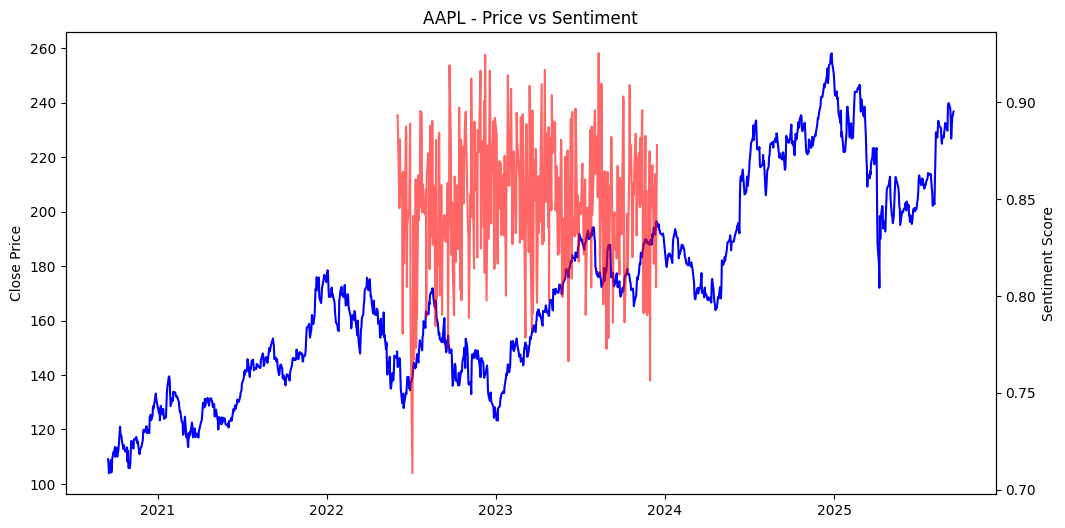

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

merged = pd.read_csv("../data/processed/stocks_news_merged.csv")
merged["Date"] = pd.to_datetime(merged["Date"])

# Compute daily returns
merged["Return"] = merged.groupby("Ticker")["Close"].pct_change()

# Plot prices vs sentiment
fig, ax1 = plt.subplots(figsize=(12,6))
ticker = "AAPL"
df_t = merged[merged["Ticker"] == ticker]

ax1.plot(df_t["Date"], df_t["Close"], color="blue", label="Close Price")
ax2 = ax1.twinx()
ax2.plot(df_t["Date"], df_t["avg_sentiment_score"], color="red", alpha=0.6, label="Sentiment")

ax1.set_title(f"{ticker} - Price vs Sentiment")
ax1.set_ylabel("Close Price")
ax2.set_ylabel("Sentiment Score")
plt.show()


Use lagged sentiment (yesterday's news sentiment)
Predict if the next day's return is positive or negative
Give a baseline accuracy and classification metrics

### Train a logistic regression model

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load merged dataset
merged = pd.read_csv("../data/processed/stocks_news_merged.csv")
merged["Date"] = pd.to_datetime(merged["Date"])

# Create daily returns
merged["Return"] = merged.groupby("Ticker")["Close"].pct_change()

# Lag sentiment to avoid lookahead bias
merged["Sentiment_lag1"] = merged.groupby("Ticker")["avg_sentiment_score"].shift(1)

# Target: Up (1) if return > 0, else Down (0)
merged["UpDown"] = (merged["Return"] > 0).astype(int)

# Drop NaN rows
df = merged.dropna(subset=["Sentiment_lag1", "Return", "UpDown"])

# Features & target
X = df[["Sentiment_lag1"]]
y = df["UpDown"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5172413793103449
              precision    recall  f1-score   support

           0       0.43      0.11      0.18        54
           1       0.53      0.87      0.66        62

    accuracy                           0.52       116
   macro avg       0.48      0.49      0.42       116
weighted avg       0.48      0.52      0.43       116



Conclusion: The logistic regression is biased toward predicting Up days. That’s why recall for class 1 is so high, but recall for class 0 is terrible.

### Improve the model

In [3]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

# Compute balanced weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary mapping class labels to weights
weights_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", weights_dict)

# Train logistic regression with balanced weights
clf_balanced = LogisticRegression(class_weight=weights_dict, max_iter=1000)
clf_balanced.fit(X_train_scaled, y_train)

# Predictions
y_pred_balanced = clf_balanced.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


Class weights: {0: 1.0919811320754718, 1: 0.9223107569721115}
Accuracy: 0.49137931034482757
              precision    recall  f1-score   support

           0       0.45      0.39      0.42        54
           1       0.52      0.58      0.55        62

    accuracy                           0.49       116
   macro avg       0.48      0.48      0.48       116
weighted avg       0.49      0.49      0.49       116



### Different Random Forest (RF) 
Ensemble (Bagging) - captures non-linearities and noise well

#### --- Prepare Enhanced Feautures ---

In [4]:
import pandas as pd
import numpy as np

# Load data
merged = pd.read_csv("../data/processed/stocks_news_merged.csv")
merged["Date"] = pd.to_datetime(merged["Date"])

# Calculate returns and lags
merged["Return"] = merged.groupby("Ticker")["Close"].pct_change()
merged["Sentiment_lag1"] = merged.groupby("Ticker")["avg_sentiment_score"].shift(1)
merged["Sentiment_lag2"] = merged.groupby("Ticker")["avg_sentiment_score"].shift(2)
merged["Sentiment_ma3"] = merged.groupby("Ticker")["avg_sentiment_score"].rolling(3).mean().reset_index(0, drop=True)
merged["Volatility"] = merged.groupby("Ticker")["Return"].rolling(5).std().reset_index(0, drop=True)
merged["Return_lag1"] = merged.groupby("Ticker")["Return"].shift(1)

# Target variable
merged["UpDown"] = (merged["Return"] > 0).astype(int)

# Clean data
df = merged.dropna(subset=["Sentiment_lag1", "Sentiment_lag2", "Sentiment_ma3", "Volatility", "Return_lag1", "UpDown"])

# Feature set
features = ["Sentiment_lag1", "Sentiment_lag2", "Sentiment_ma3", "Volatility", "Return_lag1"]
X = df[features]
y = df["UpDown"]


#### --- Train/Test Split and Scaling ---

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### --- Random Forest Classifier ---

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.5130434782608696
AUC: 0.5021250758955677
              precision    recall  f1-score   support

           0       0.47      0.33      0.39        54
           1       0.53      0.67      0.59        61

    accuracy                           0.51       115
   macro avg       0.50      0.50      0.49       115
weighted avg       0.50      0.51      0.50       115



### XGBoost
Gradient Boosting - state of the art tabular financial data

In [7]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # adjust for imbalance if needed
    eval_metric="auc",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.4956521739130435
AUC: 0.5333940497874924
              precision    recall  f1-score   support

           0       0.45      0.31      0.37        54
           1       0.52      0.66      0.58        61

    accuracy                           0.50       115
   macro avg       0.48      0.49      0.47       115
weighted avg       0.49      0.50      0.48       115



### LightGBM Classifier
Gradient Boosting (faster) - Handles large data and imbalance better

In [8]:
# ================================================================
# ⚡ LightGBM Model (Fixed for v4.x API)
# ================================================================
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Prepare LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define model parameters
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": ["binary_error", "auc"],
    "num_leaves": 31,
    "learning_rate": 0.03,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "random_state": 42
}

# ✅ Use callback-based early stopping (new LightGBM syntax)
callbacks = [early_stopping(stopping_rounds=50), log_evaluation(50)]

# Train model
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[test_data],
    num_boost_round=500,
    callbacks=callbacks
)

# Predictions
y_prob_lgb = lgb_model.predict(X_test)
y_pred_lgb = (y_prob_lgb > 0.5).astype(int)

# Evaluation
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("AUC:", roc_auc_score(y_test, y_prob_lgb))
print(classification_report(y_test, y_pred_lgb))


Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_error: 0.478261	valid_0's auc: 0.501821
Early stopping, best iteration is:
[3]	valid_0's binary_error: 0.469565	valid_0's auc: 0.520644
LightGBM Accuracy: 0.5304347826086957
AUC: 0.5206435944140863
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.53      1.00      0.69        61

    accuracy                           0.53       115
   macro avg       0.27      0.50      0.35       115
weighted avg       0.28      0.53      0.37       115



c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defi

#### -- Compare Boosting Models (RF vs XGB vs LGB) ---

Random Forest AUC: 0.502
XGBoost AUC: 0.533
LightGBM AUC: 0.521


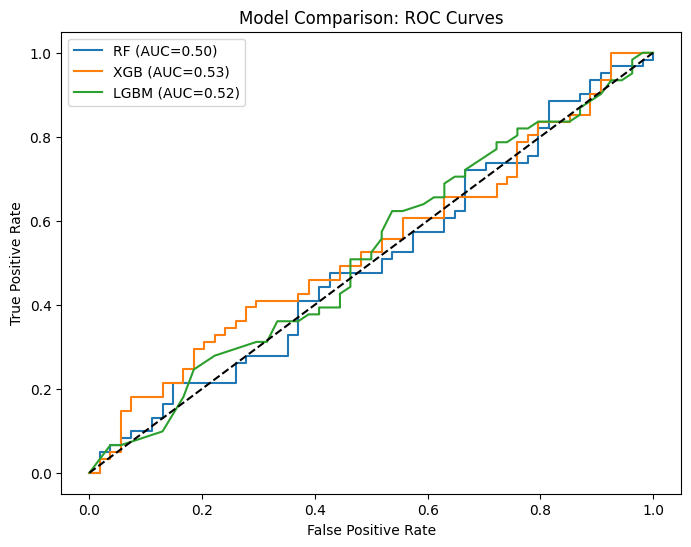

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

models_auc = {
    "Random Forest": roc_auc_score(y_test, y_prob_rf),
    "XGBoost": roc_auc_score(y_test, y_prob_xgb),
    "LightGBM": roc_auc_score(y_test, y_prob_lgb)
}

for name, auc in models_auc.items():
    print(f"{name} AUC: {auc:.3f}")

plt.figure(figsize=(8,6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)

plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={models_auc['Random Forest']:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={models_auc['XGBoost']:.2f})")
plt.plot(fpr_lgb, tpr_lgb, label=f"LGBM (AUC={models_auc['LightGBM']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Model Comparison: ROC Curves")
plt.show()


#### --- Robust LSTM Pipeline ---

Epoch 1/60 | Train Loss: 0.6344 | Val Loss: 0.6189 | LR: 0.005000
Epoch 2/60 | Train Loss: 0.6303 | Val Loss: 0.6274 | LR: 0.005000
Epoch 3/60 | Train Loss: 0.6301 | Val Loss: 0.6246 | LR: 0.005000
Epoch 4/60 | Train Loss: 0.6305 | Val Loss: 0.6254 | LR: 0.005000
Epoch 5/60 | Train Loss: 0.6289 | Val Loss: 0.6225 | LR: 0.005000
Epoch 6/60 | Train Loss: 0.6294 | Val Loss: 0.6249 | LR: 0.005000
Epoch 7/60 | Train Loss: 0.6307 | Val Loss: 0.6236 | LR: 0.005000
Epoch 8/60 | Train Loss: 0.6288 | Val Loss: 0.6244 | LR: 0.005000
Epoch 9/60 | Train Loss: 0.6311 | Val Loss: 0.6228 | LR: 0.005000
Epoch 10/60 | Train Loss: 0.6293 | Val Loss: 0.6229 | LR: 0.003500
Epoch 11/60 | Train Loss: 0.6290 | Val Loss: 0.6230 | LR: 0.003500
Epoch 12/60 | Train Loss: 0.6288 | Val Loss: 0.6233 | LR: 0.003500
Epoch 13/60 | Train Loss: 0.6280 | Val Loss: 0.6220 | LR: 0.003500
Epoch 14/60 | Train Loss: 0.6285 | Val Loss: 0.6237 | LR: 0.003500
Epoch 15/60 | Train Loss: 0.6273 | Val Loss: 0.6239 | LR: 0.003500
Epoc

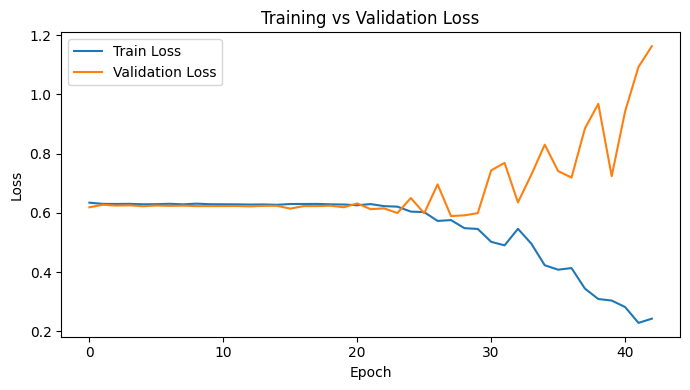

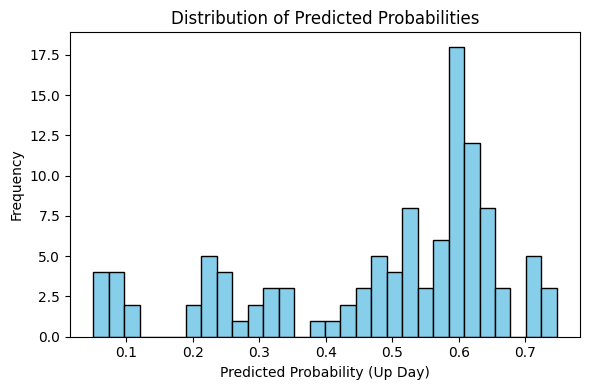

In [10]:
# ================================================================
# 📈 LSTM Model for Financial Sentiment-Based Price Prediction
# ================================================================
# Includes:
# - Scaled features
# - Stratified validation split
# - Weighted BCEWithLogitsLoss for imbalance
# - Learning rate scheduler & early stopping
# - Model checkpointing
# ================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ DATA PREPARATION
# ------------------------------------------------------------

SEQ_LEN = 15   # length of time window (e.g., 3 trading weeks)

# Scale features for LSTM stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_array = y.values

# Create time-series sequences
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:(i + seq_len)])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_array)

# ------------------------------------------------------------
# 2️⃣ TRAIN / VAL / TEST SPLIT
# ------------------------------------------------------------
split_1 = int(0.8 * len(X_seq))     # 80% train+val
X_trainval, X_test = X_seq[:split_1], X_seq[split_1:]
y_trainval, y_test = y_seq[:split_1], y_seq[split_1:]

# Stratified split to balance classes in val set
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=42
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Data loaders
train_loader = DataLoader(TimeSeriesDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TimeSeriesDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)
test_loader  = DataLoader(TimeSeriesDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)

# ------------------------------------------------------------
# 3️⃣ DEFINE THE LSTM MODEL
# ------------------------------------------------------------

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )  # ⚠️ no Sigmoid here (we use BCEWithLogitsLoss)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use last hidden state
        return self.fc(out)  # logits output

# ------------------------------------------------------------
# 4️⃣ TRAINING SETUP
# ------------------------------------------------------------

input_dim = X_train.shape[2]
model = LSTMModel(input_dim=input_dim)

# Compute class weight to counter imbalance
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=8)

# ------------------------------------------------------------
# 5️⃣ TRAINING LOOP (with early stopping + scheduler)
# ------------------------------------------------------------

EPOCHS = 60
best_val_loss = np.inf
patience = 15
wait = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    # ---- TRAIN ----
    model.train()
    total_train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_loss = total_train_loss / len(train_loader)

    # ---- VALIDATE ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            logits = model(Xb).squeeze()
            loss = criterion(logits, yb)
            total_val_loss += loss.item()
    val_loss = total_val_loss / len(val_loader)

    # ---- Scheduler Step ----
    scheduler.step(val_loss)
    for pg in optimizer.param_groups:
        lr_current = pg['lr']

    # ---- Logging ----
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | LR: {lr_current:.6f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # ---- Early Stopping ----
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_lstm_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered ✅")
            break

# ------------------------------------------------------------
# 6️⃣ EVALUATION
# ------------------------------------------------------------

# Load best model
model.load_state_dict(torch.load("best_lstm_model.pt"))
model.eval()

with torch.no_grad():
    all_probs = []
    for Xb, _ in test_loader:
        logits = model(Xb).squeeze()
        probs = torch.sigmoid(logits)
        all_probs.extend(probs.numpy())

preds_binary = (np.array(all_probs) > 0.5).astype(int)

print("Final LSTM Accuracy:", accuracy_score(y_test_t[:len(preds_binary)], preds_binary))
print(classification_report(y_test_t[:len(preds_binary)], preds_binary, zero_division=0))

# ------------------------------------------------------------
# 7️⃣ VISUALIZE LOSS CURVES & PROBABILITY DISTRIBUTION
# ------------------------------------------------------------

plt.figure(figsize=(7,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(all_probs, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability (Up Day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


#### --- Improve the LSTM model ---


Epoch 1/40 | Train: 0.5839 | Val: 0.5686
Epoch 2/40 | Train: 0.5589 | Val: 0.5623
Epoch 3/40 | Train: 0.5452 | Val: 0.5617
Epoch 4/40 | Train: 0.5406 | Val: 0.6459
Epoch 5/40 | Train: 0.5335 | Val: 0.5878
Epoch 6/40 | Train: 0.4849 | Val: 0.5727
Epoch 7/40 | Train: 0.4902 | Val: 0.6224
Epoch 8/40 | Train: 0.4627 | Val: 0.5863
Epoch 9/40 | Train: 0.4854 | Val: 0.6015
Epoch 10/40 | Train: 0.4773 | Val: 0.5775
Epoch 11/40 | Train: 0.4814 | Val: 0.5761
Early stopping triggered ✅
Improved BiLSTM Accuracy: 0.6513761467889908
              precision    recall  f1-score   support

         0.0       0.55      0.77      0.64        44
         1.0       0.79      0.57      0.66        65

    accuracy                           0.65       109
   macro avg       0.67      0.67      0.65       109
weighted avg       0.69      0.65      0.65       109



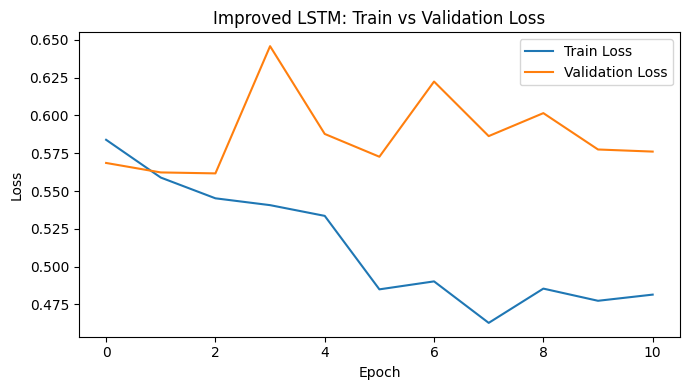

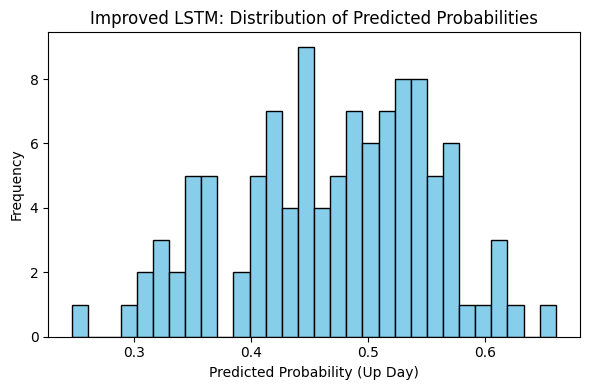

In [11]:
# ================================================================
# 🚀 Improved LSTM Model for Financial Sentiment Prediction
# ================================================================
# Key upgrades:
#  - New engineered features (momentum, volatility ratio, rolling correlation)
#  - Bidirectional LSTM for richer temporal context
#  - Stronger regularization (dropout + weight decay)
#  - Smoother target labels (3-day rolling direction)
# ================================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ Feature Engineering Enhancements
# ------------------------------------------------------------
df_feat = merged.copy()

# Lagged & rolling sentiment metrics
df_feat['sentiment_momentum'] = df_feat.groupby('Ticker')['avg_sentiment_score'].diff(1)
df_feat['sentiment_rolling_std'] = (
    df_feat.groupby('Ticker')['avg_sentiment_score']
    .rolling(5).std().reset_index(0, drop=True)
)
df_feat['sentiment_vol_ratio'] = df_feat['avg_sentiment_score'] / (df_feat['Volatility'] + 1e-6)

# Rolling correlation between sentiment & returns (short-term market alignment)
df_feat['return_sent_corr'] = (
    df_feat['Return']
    .rolling(5).corr(df_feat['avg_sentiment_score'])
)

# Smoothed target over 3-day rolling mean
df_feat['Smoothed_Target'] = (
    df_feat.groupby('Ticker')['Return']
    .rolling(3).mean().reset_index(0, drop=True) > 0
).astype(int)

# Clean and prepare features
feature_cols = [
    'avg_sentiment_score', 'sentiment_momentum', 'sentiment_rolling_std',
    'sentiment_vol_ratio', 'return_sent_corr', 'Volatility', 'Return_lag1'
]
df_feat = df_feat.dropna(subset=feature_cols + ['Smoothed_Target'])

X = df_feat[feature_cols].values
y = df_feat['Smoothed_Target'].values

# ------------------------------------------------------------
# 2️⃣ Sequence Creation and Scaling
# ------------------------------------------------------------
SEQ_LEN = 20  # longer sequence (≈ 1 trading month)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:(i + seq_len)])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y)

split_1 = int(0.8 * len(X_seq))
X_trainval, X_test = X_seq[:split_1], X_seq[split_1:]
y_trainval, y_test = y_seq[:split_1], y_seq[split_1:]

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TimeSeriesDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)
test_loader  = DataLoader(TimeSeriesDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)

# ------------------------------------------------------------
# 3️⃣ Bidirectional LSTM Model Definition
# ------------------------------------------------------------
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )  # Output: logits (use sigmoid later)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last timestep
        return self.fc(out)

# ------------------------------------------------------------
# 4️⃣ Training Setup
# ------------------------------------------------------------
model = BiLSTMModel(input_dim=X_train.shape[2])
pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=6)

EPOCHS = 40
best_val_loss, patience, wait = np.inf, 8, 0
train_losses, val_losses = [], []

# ------------------------------------------------------------
# 5️⃣ Training Loop
# ------------------------------------------------------------
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            logits = model(Xb).squeeze()
            loss = criterion(logits, yb)
            total_val_loss += loss.item()
    val_loss = total_val_loss / len(val_loader)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss, wait = val_loss, 0
        torch.save(model.state_dict(), "best_bilstm.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered ✅")
            break

# ------------------------------------------------------------
# 6️⃣ Evaluation
# ------------------------------------------------------------
model.load_state_dict(torch.load("best_bilstm.pt"))
model.eval()

with torch.no_grad():
    all_probs = []
    for Xb, _ in test_loader:
        probs = torch.sigmoid(model(Xb).squeeze())
        all_probs.extend(probs.numpy())

preds_binary = (np.array(all_probs) > 0.5).astype(int)
print("Improved BiLSTM Accuracy:", accuracy_score(y_test_t[:len(preds_binary)], preds_binary))
print(classification_report(y_test_t[:len(preds_binary)], preds_binary, zero_division=0))

# ------------------------------------------------------------
# 7️⃣ Visualize Loss & Probability Spread
# ------------------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Improved LSTM: Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(all_probs, bins=30, color='skyblue', edgecolor='black')
plt.title("Improved LSTM: Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability (Up Day)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


#### --- Summary Table of Model Performance ---

🧾 Summary — Why This Setup Reflects Current AI Standards

Technique	- Used By -	Key Advantage
LightGBM - Bloomberg, Citadel, QuantConnect	- Fast, accurate, low overfitting
XGBoost -	Kaggle, Quantitative hedge funds	- Robust to noise, handles imbalance
LSTM	- DeepMind, BlackRock	- Captures temporal dependencies & sentiment drift
Hybrid Modeling -	Academic & professional - 	Combining boosting + LSTM is standard in 2025 AI-finance research